<a href="https://colab.research.google.com/github/Jaew00/ElasticSearch/blob/main/New_Nickel_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [36]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'{device} is available')

cuda:0 is available


In [4]:
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Nickel_Final_DB1.csv')

In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df['NetWeight'] = pd.to_numeric(df['NetWeight']).astype(float)

df.set_index('Date', inplace = True)

In [6]:
df

,Price,Y2_Price,Y10_Price,UC_Price,EU_Price,GB_Price,JP_Price,NetWeight,TradeValue,WTI_Price,B_Price,Gas_Price,heating_Price,NAV,Dollor_Price,Stock,STS_price,Current_Price,CRB_Price
Date,,,,,,,,,,,,,,,,,,,
2011-01-04,25120.0,0.6210,3.338,6.6070,0.7514,0.6415,82.06,779926682.0,155396452.0,89.38,93.53,4.669,2.5065,31.64,79.440,136890.0,100.700,25175.0,327.76
2011-01-05,24720.0,0.7080,3.463,6.6193,0.7603,0.6448,83.19,779926682.0,155396452.0,90.30,95.50,4.473,2.5422,31.91,80.260,136860.0,100.700,24650.0,329.23
2011-01-06,24534.0,0.6770,3.399,6.6263,0.7686,0.6464,83.31,779926682.0,155396452.0,88.38,94.52,4.434,2.5112,31.57,80.790,137040.0,100.700,24875.0,325.10
2011-01-07,24180.0,0.5970,3.328,6.6282,0.7746,0.6428,83.14,779926682.0,155396452.0,88.03,93.33,4.422,2.4863,31.65,81.010,136896.0,100.700,24345.0,323.98
2011-01-10,23847.0,0.5730,3.287,6.6369,0.7723,0.6421,82.72,779926682.0,155396452.0,89.25,95.70,4.399,2.5561,31.88,80.880,136806.0,100.700,24050.0,326.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-23,27732.0,2.6287,2.861,6.6490,0.9352,1.2588,127.87,49104116.0,16801717.0,109.77,110.78,8.796,3.7818,22.44,102.097,71922.0,177.145,26800.0,335.74
2022-05-24,26550.0,2.4807,2.754,6.6530,0.9314,1.2529,126.80,49104116.0,16801717.0,110.33,110.69,8.971,3.8664,22.17,101.870,72120.0,177.145,26280.0,334.21
2022-05-25,26788.0,2.5020,2.751,6.6916,0.9360,1.2564,127.31,49104116.0,16801717.0,114.09,111.12,8.908,3.9680,22.06,102.077,72600.0,177.145,26725.0,335.09


In [9]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data.iloc[i:(i+seq_length)]
        y = data.iloc[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

#지도학습용 데이터로 변환
seq_length = 5
X, y = create_sequences(df, seq_length)

#학습용, 검증용, 시험용으로 분리
train_size = int(327 * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+33], y[train_size:train_size+33]
X_test, y_test = X[train_size+33:], y[train_size+33:]

MIN = X_train.min()
MAX = X_train.max()

def MinMaxScale(array, min, max):

    return (array - min) / (max - min)

#MinMax 스케일링
X_train = MinMaxScale(X_train, MIN, MAX)
y_train = MinMaxScale(y_train, MIN, MAX)
X_val = MinMaxScale(X_val, MIN, MAX)
y_val = MinMaxScale(y_val, MIN, MAX)
X_test = MinMaxScale(X_test, MIN, MAX)
y_test = MinMaxScale(y_test, MIN, MAX)

#Tensor 형태로 변환
def make_Tensor(array):
    return torch.torch.tensor(array, device=device).float()

X_train = make_Tensor(X_train)
y_train = make_Tensor(y_train)
X_val = make_Tensor(X_val)
y_val = make_Tensor(y_val)
X_test = make_Tensor(X_test)
y_test = make_Tensor(y_test)



In [10]:
x_cols = list(df.columns)
x_cols.remove("Price")

test_data_size = 700
X = df[x_cols]
Y = df['Price']


scaler = MinMaxScaler()

Xscaler = scaler.fit(X)
Yscaler = scaler.fit(Y.values.reshape(-1,1))

Y = Y.values.reshape(-1, 1)

X_train = scaler.fit_transform(X[:-test_data_size])
X_test = scaler.transform(X[-test_data_size:])
y_train = scaler.fit_transform(Y[:-test_data_size]).flatten()
y_test = scaler.transform(Y[-test_data_size:]).flatten()

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2083, 18)
(700, 18)
(2083,)
(700,)


In [11]:
def create_sequences(array, seq_length) :
  res = []
  if seq_length == 1:
    for i in range(len(array)) :
      tmp = array[i:(i+seq_length)]
      res.append(tmp)

  else :
    for i in range(len(array) - seq_length-1) :
      tmp = array[i:(i+seq_length)]
      res.append(tmp)

  return res

In [12]:
seq_length = 1

X_train = create_sequences(X_train, seq_length)
X_test = create_sequences(X_test, seq_length)
y_train = create_sequences(y_train, seq_length)
y_test = create_sequences(y_test, seq_length)

In [13]:
X_train = torch.tensor(X_train, device=device).float()
X_test = torch.tensor(X_test, device=device).float()
y_train = torch.tensor(y_train, device=device).float()
y_test = torch.tensor(y_test, device=device).float()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  """Entry point for launching an IPython kernel.


In [14]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

torch.Size([2083, 1, 18]) torch.Size([700, 1, 18])
torch.Size([2083, 1]) torch.Size([700, 1])


# Building a Model

LSTM

In [15]:
class LSTM(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers):
        super(LSTM, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers
        )
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden, device=device),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden, device=device)
        )
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(
            sequences.view(len(sequences), self.seq_len, -1),
            self.hidden
        )
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred

CNN-LSTM

In [16]:
class CNN_LSTM(nn.Module) :
  def __init__(self, n_features, n_hidden, seq_len, n_layers = 2) :
    super(LSTM, self).__init__()
    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers
    self.c1 = nn.Conv1d(in_channels=1, out_channels=n_features, kernel_size = 2, stride = 1) # 1D CNN 레이어 추가
    self.lstm = nn.LSTM(
        input_size = n_features,
        hidden_size=n_hidden,
        num_layers=n_layers
        )
    
    self.linear = nn.Linear(in_features = n_hidden, out_features = 1)


  def reset_hidden_state(self) :
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len-1, self.n_hidden, device=device),
        torch.zeros(self.n_layers, self.seq_len-1, self.n_hidden, device=device)
    )

  def forward(self, sequences) :
    sequences = self.c1(sequences.view(len(sequences), 1, -1))
    lstm_out, self.hidden = self.lstm(
        sequences.view(sequences.size(0), self.seq_len-1, -1),
        self.hidden
    )
    last_time_step = lstm_out.view(self.seq_len-1, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred

# Training

In [17]:
def train_model(model, train_data, train_labels, test_data = None, test_labels=None, num_epochs = 250, lr = 1e-3) :
  loss_fn = torch.nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay=1e-4)
  num_epochs = num_epochs

  train_hist = np.zeros(num_epochs)
  val_hist = np.zeros(num_epochs)

  for i in range(num_epochs) :
    model.reset_hidden_state()
    y_pred = model(X_train)
    loss = loss_fn(y_pred.float(), y_train)

    if test_data is not None :
      with torch.no_grad() :
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      val_hist[i] = test_loss.item()

      if i % 10 == 0:
        print(f'Epoch {i} train loss: {round(loss.item(),4)} test loss: {round(test_loss.item(),4)}')
    elif i % 10 == 0 :
      print(f'Epoch {i} train loss: {round(loss.item(),4)}')

    train_hist[i] = loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  return model.eval(), train_hist, val_hist

In [22]:
def train_model(model, train_data, train_labels, val_data=None, val_labels=None, num_epochs=100, verbose = 10, patience = 10):
    loss_fn = torch.nn.L1Loss() #
    optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
    train_hist = []
    val_hist = []
    for t in range(num_epochs):

        epoch_loss = 0

        for idx, seq in enumerate(train_data): 

            model.reset_hidden_state() # seq 별 hidden state reset

            # train loss
            seq = torch.unsqueeze(seq, 0)
            y_pred = model(seq)
            loss = loss_fn(y_pred[0].float(), train_labels[idx]) # 1개의 step에 대한 loss

            # update weights
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            epoch_loss += loss.item()

        np.append(train_hist, (epoch_loss / len(train_data)))

        if val_data is not None:

            with torch.no_grad():

                val_loss = 0

                for val_idx, val_seq in enumerate(val_data):

                    model.reset_hidden_state() # seq 별로 hidden state 초기화 

                    val_seq = torch.unsqueeze(val_seq, 0)
                    y_val_pred = model(val_seq)
                    val_step_loss = loss_fn(y_val_pred[0].float(), val_labels[val_idx])

                    val_loss += val_step_loss

            np.append(val_hist, (val_loss / len(val_data)).cpu()) # val hist에 추가

            ## verbose 번째 마다 loss 출력 
            if t % verbose == 0:
                print(f'Epoch {t} train loss: {epoch_loss / len(train_data)} val loss: {val_loss / len(val_data)}')

            '''## patience 번째 마다 early stopping 여부 확인
            if (t % patience == 0) & (t != 0):
                
                ## loss가 커졌다면 early stop
                if val_hist[t - patience] < val_hist[t] :

                    print('\n Early Stopping')
                    break'''

        elif t % verbose == 0:
            print(f'Epoch {t} train loss: {epoch_loss / len(train_data)}')

            
    return model, train_hist, val_hist

In [23]:
model = LSTM(
    n_features=X_train.shape[-1],
    n_hidden=4,
    seq_len=seq_length,
    n_layers=1
).to(device)
model, train_hist, val_hist = train_model(
    model,
    X_train,
    y_train,
    X_test,
    y_test,
    num_epochs=100,
    verbose=10,
    patience=50
)

Epoch 0 train loss: 0.09898239245125867 val loss: 0.20339679718017578
Epoch 10 train loss: 0.020278560626309363 val loss: 0.1677275151014328
Epoch 20 train loss: 0.015611468388221039 val loss: 0.1338324248790741
Epoch 30 train loss: 0.013457310991831199 val loss: 0.12207239121198654
Epoch 40 train loss: 0.012092514564491097 val loss: 0.11231095343828201
Epoch 50 train loss: 0.011667553384609938 val loss: 0.10460105538368225
Epoch 60 train loss: 0.010484772318087972 val loss: 0.10225123912096024
Epoch 70 train loss: 0.009645875297447436 val loss: 0.0969017893075943
Epoch 80 train loss: 0.009504111213640873 val loss: 0.09433025866746902
Epoch 90 train loss: 0.009078295735094161 val loss: 0.09764280170202255


NameError: ignored

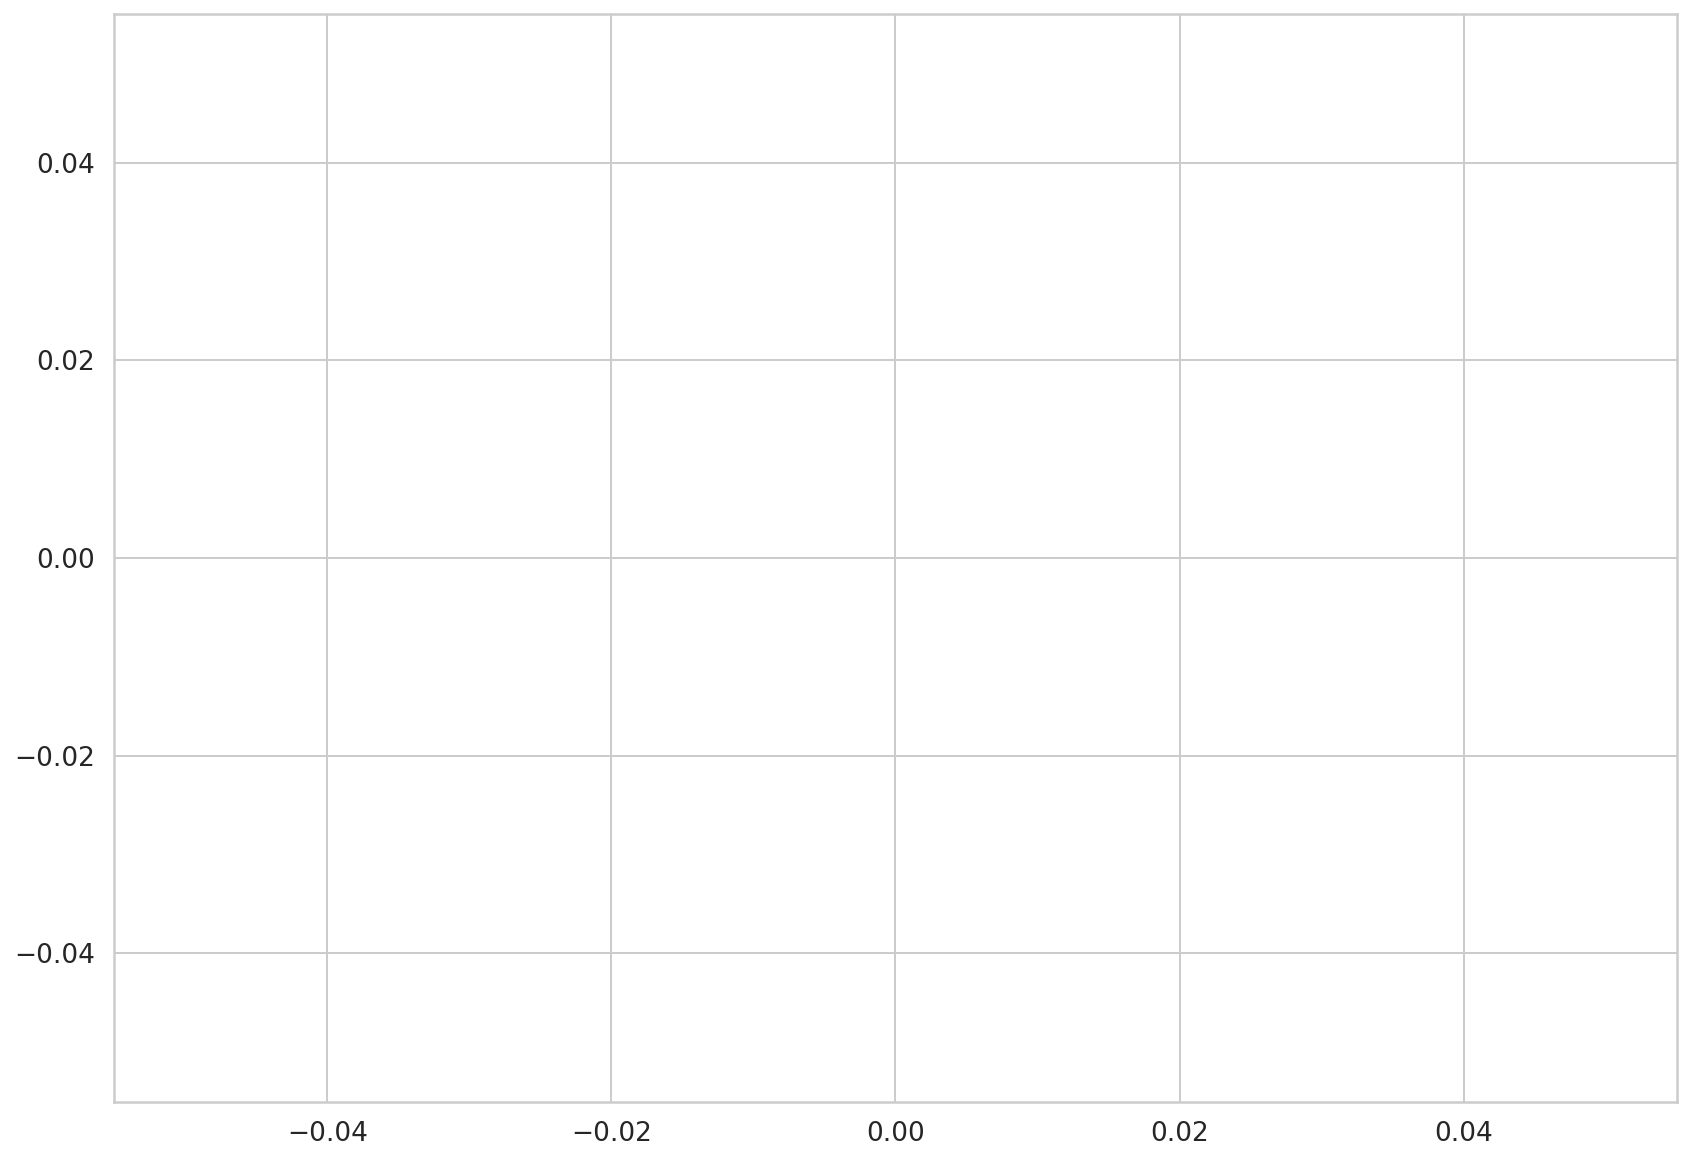

In [27]:
# plotting Loss
plt.plot(train_hist, label="Training loss")
plt.plot(val_hist, label="Test loss")
plt.title('n_features:{0}, n_hidden:{1}, n_layers:{2}, lr:{3}, seq_length:{4}, num_epochs:{5}'.format(n_features,n_hidden,n_layers,lr,seq_length,num_epochs))
plt.legend()

In [25]:
with torch.no_grad():
  preds = []
  for i in range(len(X_test)):
    test_seq = X_test[i:i+1]
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.cpu().numpy().flatten()
    new_seq = np.append(new_seq, pred)
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(X_train.shape[-1], seq_length, 1).float()

In [28]:
preds


[0.5619078874588013,
 0.5813387036323547,
 0.5980210304260254,
 0.610562801361084,
 0.6099602580070496,
 0.6131960153579712,
 0.614258885383606,
 0.6159964203834534,
 0.6099260449409485,
 0.6222888827323914,
 0.6310035586357117,
 0.634329617023468,
 0.6399098634719849,
 0.6458569169044495,
 0.6465789675712585,
 0.6494959592819214,
 0.6506739258766174,
 0.6475288271903992,
 0.6445067524909973,
 0.6426818370819092,
 0.639004111289978,
 0.6373856663703918,
 0.636820375919342,
 0.6427768468856812,
 0.6651349067687988,
 0.673693835735321,
 0.6795463562011719,
 0.6794755458831787,
 0.6804693341255188,
 0.6871289014816284,
 0.6924351453781128,
 0.6964914798736572,
 0.6982348561286926,
 0.6975178718566895,
 0.6940520405769348,
 0.6871179342269897,
 0.685530960559845,
 0.683678388595581,
 0.6900581121444702,
 0.6903587579727173,
 0.6840293407440186,
 0.6803331971168518,
 0.6791182160377502,
 0.6784934997558594,
 0.6779041886329651,
 0.6832488179206848,
 0.6880286335945129,
 0.6912930011749268,


In [30]:
# Prediction value 스케일링 역변환
pred_values = Yscaler.inverse_transform(np.array(preds).reshape(-1,1))

In [31]:
pred_values

array([[19692.37208009],
       [20110.87299883],
       [20470.17695332],
       [20740.30161572],
       [20727.32403696],
       [20797.01577878],
       [20819.90787339],
       [20857.33090222],
       [20726.58715594],
       [20992.85795629],
       [21180.5546459 ],
       [21252.19129145],
       [21372.37863946],
       [21500.46627629],
       [21516.01780355],
       [21578.84397101],
       [21604.21501553],
       [21536.47588003],
       [21471.38643515],
       [21432.08140707],
       [21352.87054896],
       [21318.01248229],
       [21305.83725655],
       [21434.12772822],
       [21915.67562199],
       [22100.01783407],
       [22226.06941986],
       [22224.54430723],
       [22245.9485184 ],
       [22389.38228011],
       [22503.66816115],
       [22591.03349352],
       [22628.5823313 ],
       [22613.13992405],
       [22538.49284995],
       [22389.14606738],
       [22354.96582854],
       [22315.06513357],
       [22452.47161937],
       [22458.94692922],


In [34]:
pred_values_ceiled  = list(pred_values.flatten())

# True value 스케일링 역변환
true_values = Yscaler.inverse_transform(np.array(y_test.cpu()).reshape(-1,1))
# 실제값 예측값 데이터 프레임 생성

score_table = pd.DataFrame({'True':true_values.flatten(),
                            'Pred':pred_values_ceiled})

score_table

,True,Pred
0,14137.999023,19692.372080
1,14345.000000,20110.872999
2,14307.999023,20470.176953
3,14553.000000,20740.301616
4,14473.000000,20727.324037
...,...,...
695,27731.998047,24875.354378
696,26550.000000,24870.883025
697,26788.000000,24875.000059
698,27197.998047,24884.297084


In [37]:
# validation score
MSE = mean_squared_error(score_table['True'], score_table['Pred'])
RMSE = np.sqrt(MSE)
score = 100*(1-(((score_table['Pred'] -score_table['True'])**2).sum())/((score_table['True']**2).sum()))

print("MSE : {0}, RMSE : {1}, SCORE : {2}".format(MSE, RMSE, score))

MSE : 34969542.07869301, RMSE : 5913.5050586511725, SCORE : 90.09562557576122


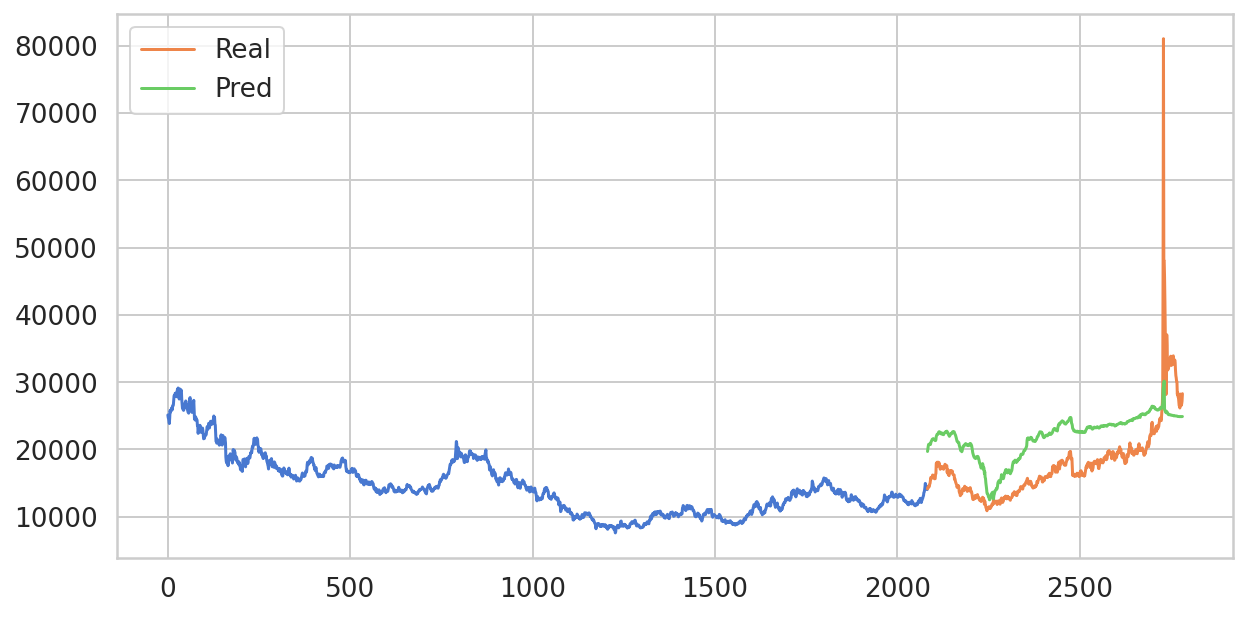

In [38]:
plt.figure(figsize=(10,5))
plt.plot(range(y_train.__len__()),Yscaler.inverse_transform(np.array(y_train.cpu()).reshape(-1,1)))
plt.plot(range(y_train.__len__(), y_train.__len__()+y_test.__len__()),true_values, label='Real')
plt.plot(range(y_train.__len__(), y_train.__len__()+y_test.__len__()),pred_values_ceiled, label='Pred')
#plt.xlim(70)
plt.legend()